## Questions/Answers over time

In [1]:
from pyspark.sql import (
    SparkSession,
    functions as f
    )
import matplotlib



22/11/12 15:33:49 WARN Utils: Your hostname, legion resolves to a loopback address: 127.0.1.1; using 192.168.1.88 instead (on interface wlp4s0)
22/11/12 15:33:49 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/11/12 15:33:49 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
22/11/12 15:33:50 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [ ]:
spark = SparkSession.builder.master("local[12]").appName("Analytics").getOrCreate()

In [2]:
posts = spark.read.format('parquet').load("outputs/posts")
posts.show(1, vertical=True)

-RECORD 0----------------------------------------
 accepted_answer_id       | 4                    
 answer_count             | 1                    
 body                     | <p>I was offered ... 
 body_clean               | I was offered a b... 
 closed_date              | null                 
 comment_count            | 0                    
 community_owned_date     | null                 
 content_licence          | CC BY-SA 3.0         
 creation_date            | 2014-01-21 21:26:... 
 favourite_count          | null                 
 id                       | 1                    
 last_activity_date       | 2014-01-21 23:04:... 
 last_edit_date           | 2014-01-21 23:04:... 
 last_editor_display_name | null                 
 last_editor_user_id      | 8                    
 owner_user_id            | 7                    
 post_type_id             | 1                    
 parent_id                | null                 
 score                    | 21                   


In [3]:
posts_grouped = (
    posts
    .filter(f.col('owner_user_id').isNotNull())
    .groupBy(
        f.window('creation_date', '4 weeks')
    )
    .agg(
        f.sum(f.lit(1)).alias('all'),
        f.sum(f.when(f.col('post_type_id') == 1, f.lit(1)).otherwise(f.lit(0))).alias('questions'),
        f.sum(f.when(f.col('post_type_id') == 2, f.lit(1)).otherwise(f.lit(0))).alias('answers')
    )
    # window struct has nested columns 'start' and 'end'
    .withColumn('date', f.col('window.start').cast('date'))
    .orderBy('date')
).toPandas()



In [4]:
posts_grouped.head()

,window,all,questions,answers,date
0,"(2014-01-02 01:00:00, 2014-01-30 01:00:00)",413,150,243,2014-01-02
1,"(2014-01-30 01:00:00, 2014-02-27 01:00:00)",190,58,118,2014-01-30
2,"(2014-02-27 01:00:00, 2014-03-27 01:00:00)",50,16,34,2014-02-27
3,"(2014-03-27 01:00:00, 2014-04-24 02:00:00)",47,16,31,2014-03-27
4,"(2014-04-24 02:00:00, 2014-05-22 02:00:00)",44,10,34,2014-04-24


In [5]:
# posts_grouped.plot(
#     x='date', 
#     figsize=(12, 6), 
#     title='Number of questions/answers per month (4 weeks)',
#     legend=True,
#     xlabel='Date',
#     ylabel='Count',
#     kind='line'
# )

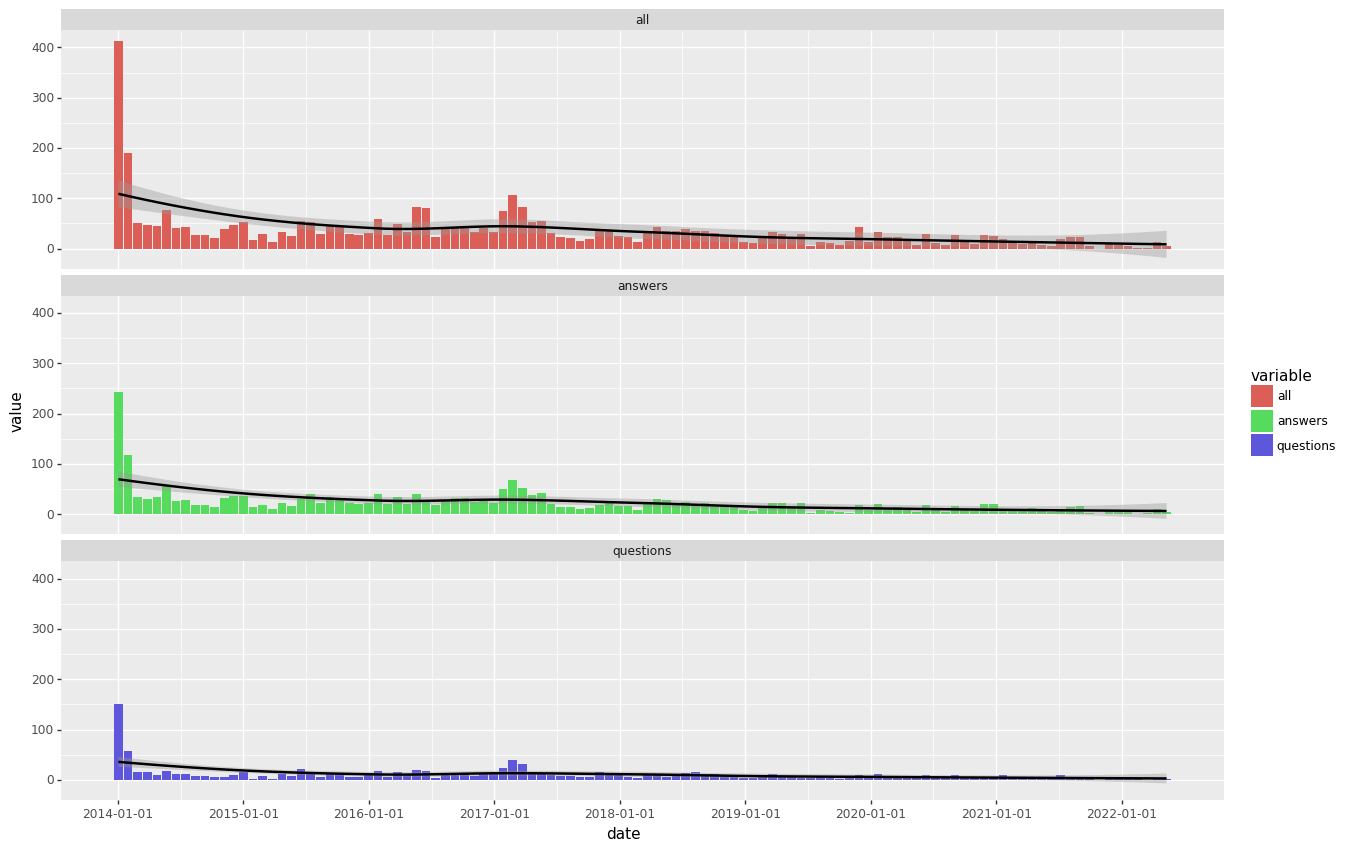

<ggplot: (8751471343053)>

In [6]:
from plotnine import aes, facet_wrap, ggplot, scale_x_datetime, options, stat_smooth, geom_col

options.figure_size = (15, 10)

posts_long = posts_grouped.melt(id_vars=('date'), value_vars=('all', 'questions', 'answers'))
posts_long.head()

(ggplot(posts_long, aes(x='date', y='value', group='variable'))
+ geom_col(aes(fill='variable')) 
+ scale_x_datetime()
+ stat_smooth(method='loess') 
+ facet_wrap('variable', ncol=1)
)


## Forum retention - time from account creation to last comments

In [7]:
users = spark.read.format('parquet').load("outputs/users").select(f.col('id'), f.col('creation_date'), f.col('display_name'))

In [8]:
users.show()

+---+--------------------+----------------+
| id|       creation_date|    display_name|
+---+--------------------+----------------+
| -1|2014-01-21 18:45:...|       Community|
|  1|2014-01-21 21:21:...|    Geoff Dalgas|
|  2|2014-01-21 21:22:...|  Kasra Rahjerdi|
|  3|2014-01-21 21:22:...|       Adam Lear|
|  4|2014-01-21 21:22:...|   Arie Litovsky|
|  5|2014-01-21 21:22:...|    Brian Nickel|
|  6|2014-01-21 21:23:...|        Jeremy T|
|  7|2014-01-21 21:24:...|      Tom Medley|
|  8|2014-01-21 21:25:...|LessPop_MoreFizz|
|  9|2014-01-21 21:25:...|     Nick Craver|
| 10|2014-01-21 21:28:...|          ChrisG|
| 11|2014-01-21 21:28:...|        hairboat|
| 12|2014-01-21 21:29:...|        nhaarman|
| 13|2014-01-21 21:29:...|           Shog9|
| 14|2014-01-21 21:32:...|     Ben Collins|
| 15|2014-01-21 21:33:...|             Ana|
| 16|2014-01-21 21:34:...|      Grace Note|
| 17|2014-01-21 21:34:...|     Jon Ericson|
| 18|2014-01-21 21:36:...|         awesame|
| 19|2014-01-21 21:36:...|   Ste

In [13]:
posts_by_user = posts.select(f.col('owner_user_id'), f.col('last_activity_date'), f.col('id').alias('post_id'))

In [24]:
posts_and_users_joined = (users
    .filter(f.col('id') != -1) # remove bots
    .join(posts_by_user, users.id  == posts_by_user.owner_user_id, how="left" )
    .filter(f.col('post_id').isNotNull()) # remove users that never posted
)

posts_and_users_joined.show()

+---+--------------------+--------------+-------------+--------------------+-------+
| id|       creation_date|  display_name|owner_user_id|  last_activity_date|post_id|
+---+--------------------+--------------+-------------+--------------------+-------+
|  2|2014-01-21 21:22:...|Kasra Rahjerdi|            2|2014-01-22 01:26:...|     39|
|  2|2014-01-21 21:22:...|Kasra Rahjerdi|            2|2014-01-22 06:50:...|     28|
|  4|2014-01-21 21:22:...| Arie Litovsky|            4|2016-03-06 05:31:...|     85|
|  5|2014-01-21 21:22:...|  Brian Nickel|            5|2014-02-05 00:20:...|    533|
|  5|2014-01-21 21:22:...|  Brian Nickel|            5|2014-01-23 17:41:...|    267|
|  5|2014-01-21 21:22:...|  Brian Nickel|            5|2014-01-22 19:36:...|    217|
|  5|2014-01-21 21:22:...|  Brian Nickel|            5|2018-08-09 17:38:...|     50|
|  5|2014-01-21 21:22:...|  Brian Nickel|            5|2014-01-21 21:59:...|     32|
|  5|2014-01-21 21:22:...|  Brian Nickel|            5|2014-01-21

In [29]:
posts_and_users_joined.select(f.col('post_id')).count() == posts_and_users_joined.select(f.col('post_id')).distinct().count()

True

In [88]:
user_last_post = (posts_and_users_joined
    .groupBy(f.col('id'), f.col('creation_date'))
    .agg(
        f.max(f.col('last_activity_date'))
    )
)

# time from account creation to last activity
user_last_post = user_last_post.withColumn('diff',f.datediff(f.col('max(last_activity_date)'), f.col('creation_date')) )
user_last_post.show()

+-----+--------------------+-----------------------+----+
|   id|       creation_date|max(last_activity_date)|diff|
+-----+--------------------+-----------------------+----+
| 6696|2017-04-27 20:46:...|   2017-09-18 23:40:...| 144|
| 7212|2017-10-24 03:20:...|   2017-10-24 03:20:...|   0|
| 7311|2017-11-29 00:29:...|   2017-12-23 15:32:...|  24|
|10039|2020-01-17 21:47:...|   2020-03-25 22:19:...|  68|
|  149|2014-01-22 17:41:...|   2014-01-23 09:52:...|   1|
|  736|2014-04-03 15:25:...|   2017-01-27 15:13:...|1030|
| 4197|2015-06-10 21:13:...|   2015-06-10 21:18:...|   0|
| 5654|2016-07-13 11:17:...|   2016-09-02 14:08:...|  51|
| 7154|2017-10-01 08:24:...|   2017-10-01 08:24:...|   0|
| 7286|2017-11-23 12:43:...|   2017-11-24 23:07:...|   1|
| 7936|2018-07-20 11:31:...|   2018-07-24 13:49:...|   4|
|11698|2020-11-12 21:24:...|   2020-11-12 21:24:...|   0|
| 1295|2014-09-10 19:56:...|   2016-10-08 16:17:...| 759|
| 5893|2016-09-11 05:06:...|   2016-09-11 05:07:...|   0|
| 6636|2017-04

In [51]:
user_last_post.select(f.col('id')).count() == user_last_post.select(f.col('id')).distinct().count()

True

/home/michalk/Documents/big_data/final-project/.venv/lib/python3.9/site-packages/pyspark/sql/pandas/conversion.py:248: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
/home/michalk/Documents/big_data/final-project/.venv/lib/python3.9/site-packages/pyspark/sql/pandas/conversion.py:248: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead


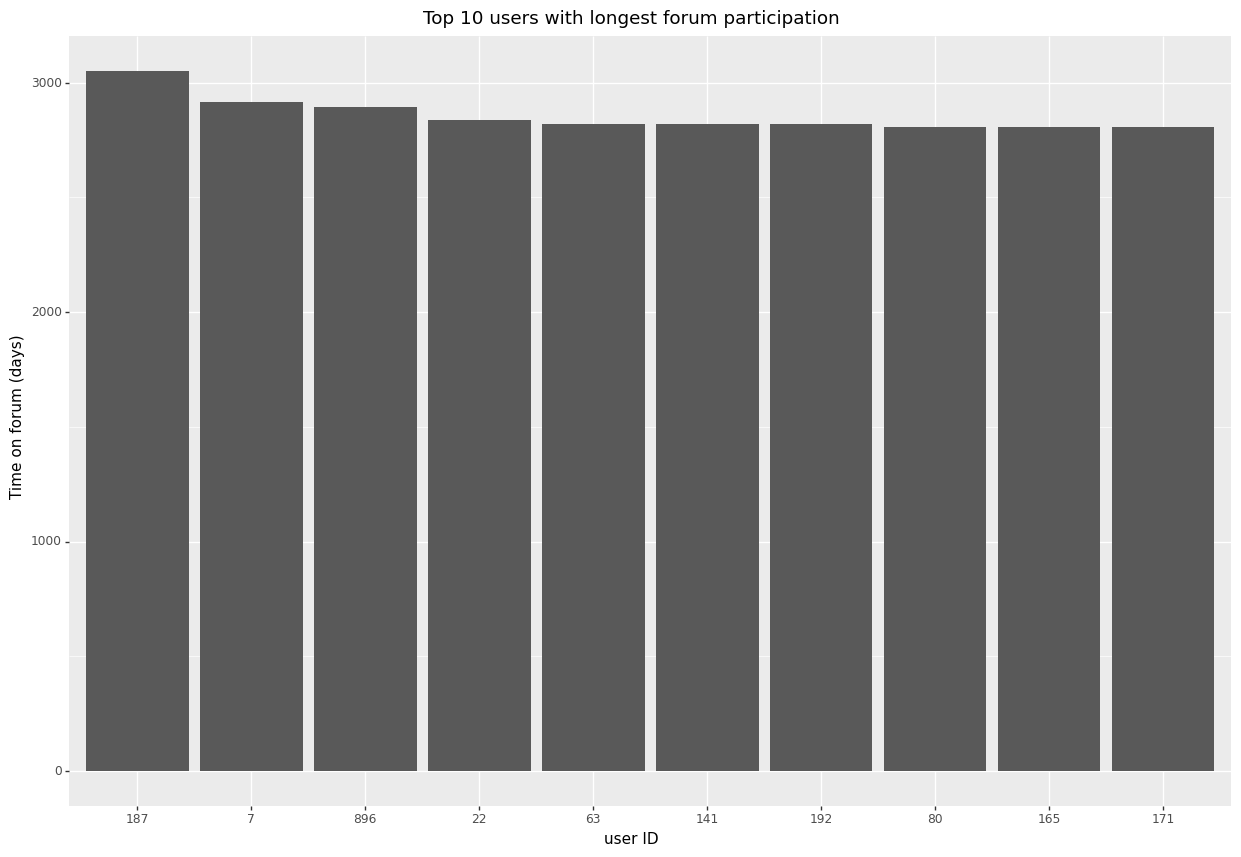

<ggplot: (8751405162183)>

In [87]:

user_last_post_df = user_last_post.orderBy(f.col('diff').desc()).limit(10).withColumn('id_cat', f.col('id').cast('string')).toPandas()

import pandas as pd
# add sorted categories for pretty plotting
user_last_post_df['id_cat'] = pd.Categorical(user_last_post_df.id_cat, categories=user_last_post_df.id_cat)

from plotnine import labs
(ggplot(user_last_post_df, aes(x='id_cat', y='diff'))
     + geom_col()
     + labs(x='user ID', y='Time on forum (days)', title='Top 10 users with longest forum participation')
)

## porównanie najwyżej i najniżej ocenianych pytań (długość, tagi, liczba odpowiedzi)

## procent przypadków kiedy najwyżej oceniana odpowiedź to nie zaakceptowana odpowiedź

## rozkład ocen odpowiedzi zaakceptowanych vs pozostałych (średnia, odchylenie, minimum, maksimum)

## top N tagów które wygenerowały najwięcej wyświetleń

## liczba postów w czasie dla każdego z top N tagów (lineplot/barplot)

## najczęściej pojawiające się słowa w tytułach (z pominięciem stopwords

## procent użytkowników którzy nigdy nic nie zapostowali

## średni czas od pojawienia się pytania do pojawienia się zaakceptowanej odpowiedzi